<a href="https://colab.research.google.com/github/benmaors/CS231-Deep-Learning/blob/main/assignment1/knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

## Setup Google Colab Environment

1. Clone repo to download supporting python files
2. Install Python dependencies with pip
3. Download CIFAR-10 data set

In [2]:
cd /content

/content


In [3]:
!ls

sample_data


In [4]:
!git clone https://github.com/nholmber/google-colab-cs231n.git

Cloning into 'google-colab-cs231n'...
remote: Enumerating objects: 109, done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 109
Receiving objects: 100% (109/109), 5.07 MiB | 9.51 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [5]:
%cd google-colab-cs231n/assignment1

/content/google-colab-cs231n/assignment1


In [6]:
!pip install imageio

In [7]:
%cd cs231n/datasets/
!ls

/content/google-colab-cs231n/assignment1/cs231n/datasets
get_datasets.sh


In [8]:
!more get_datasets.sh

# Get CIFAR10
wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz
rm cifar-10-python.tar.gz 


In [9]:
!./get_datasets.sh

--2021-07-08 10:35:50--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  44.9MB/s    in 4.1s    

2021-07-08 10:35:54 (39.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [10]:
%cd ../..
!ls

/content/google-colab-cs231n/assignment1
collectSubmission.sh  README.md		    svm.ipynb
cs231n		      requirements.txt	    two_layer_net_colab.ipynb
features.ipynb	      setup_googlecloud.sh  two_layer_net.ipynb
frameworkpython       softmax.ipynb
knn.ipynb	      start_ipython_osx.sh


---
## Start Building kNN Model


In [11]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Define function for inspecting the source code of a function
import inspect
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import Terminal256Formatter

def pretty_print(func):
  source_code = inspect.getsourcelines(func)[0]
  for line in source_code:
    print(highlight(line.strip('\n'), PythonLexer(), Terminal256Formatter()), end='')
  print('')

In [12]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


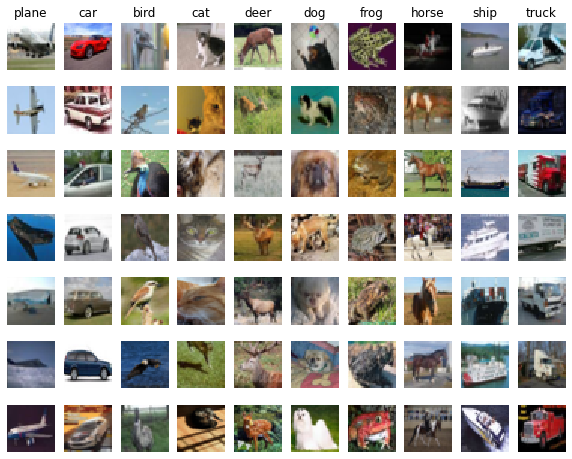

In [13]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [14]:
enumerate(classes)

In [15]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [16]:
 (X_train.shape[0], -1)

(5000, -1)

In [17]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1)) # we use (-1) because we want the shape to be according to the number of pixels the image has. using (-1) means this dimension is automatially calculated
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [18]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)


We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [20]:
def compute_distances_two_loops(self,X):

  ''' Compute the distance between each test point in X and each training point in self.X_train using a nested loop over both the training data and the test data.
  Inputs: 
  X: np. array of shape (num_test, D) containing test data 

  Returns:
  dists: np. array of shape (num_test, num_train) where dists[i,j] is the euclidean distance between i_th test point and jth training point
  ''' 

  num_test = X.shape[0]
  num_train = self.X_train.shape[0]
  dists = np.zeros((num_test, num_train))
  for i in range(num_test):
    for j in range(num_train):
      dists[i,j] = np.linalg.notm(X[i]-self.X_train[j])


    for i in range(num_test):
      # Note axis=1 computes norm along rows
      dists[i] = np.linalg.norm(X[i]-self.X_train, axis=1)
  
  return dists 

In [21]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.
# Print out implementation
pretty_print(classifier.compute_distances_two_loops)

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)



  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      for j in range(num_train):
        dists[i, j] = np.linalg.norm(X[i]-self.X_train[j])

    return dists

(500, 5000)


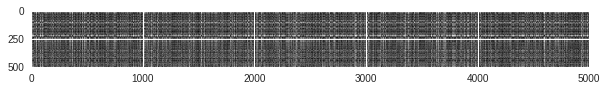

In [ ]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: 



In [23]:
def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.
    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.
    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.
      closest_y = []
      #########################################################################
      # TODO:                                                                 #
      # Use the distance matrix to find the k nearest neighbors of the ith    #
      # testing point, and use self.y_train to find the labels of these       #
      # neighbors. Store these labels in closest_y.                           #
      # Hint: Look up the function numpy.argsort.                             #
      #########################################################################
      closest_y = self.y_train[np.argsort(dists[i])][0:k]
      #########################################################################
      # TODO:                                                                 #
      # Now that you have found the labels of the k nearest neighbors, you    #
      # need to find the most common label in the list closest_y of labels.   #
      # Store this label in y_pred[i]. Break ties by choosing the smaller     #
      # label.                                                                #
      #########################################################################
      y_pred[i] = np.bincount(closest_y).argmax()
      #########################################################################
      #                           END OF YOUR CODE                            # 
      #########################################################################

    return y_pred

In [24]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [25]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**
We can also other distance metrics such as L1 distance.
The performance of a Nearest Neighbor classifier that uses L1 distance will not change if (Select all that apply.):
1. The data is preprocessed by subtracting the mean.
2. The data is preprocessed by subtracting the mean and dividing by the standard deviation.
3. The coordinate axes for the data are rotated.
4. None of the above.

*Your Answer*:

*Your explanation*:


In [26]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:

# Print out implementation
pretty_print(classifier.compute_distances_one_loop)

# Now run calculation
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      # Note axis=1 computes norm along rows
      dists[i] = np.linalg.norm(X[i]-self.X_train, axis=1)

    return dists

Difference was: 0.000000
Good! The distance matrices are the same


In [27]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code

# Print out implementation
pretty_print(classifier.compute_distances_no_loops)

# Now run calculation
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]

    # Expand ||x - y||**2 = ||x||**2 - 2 x.T ⋅y + ||y||**2,
    # where ||x||**2 = sum(x**2) (element-wise on matrix rows)
    # The final result is a (num_test, num_train) matrix
    # so the x**2 and y**2 intermediates must be reshaped appropriately
    x2 = np.sum(X**2, axis=1).reshape((num_test, 1))
    y2 = np.sum(self.X_train**2, axis=1).reshape((1, num_train))
    xy = -2*np.matmul(X, self.X_train.T)
    dists = np.sqrt(x2 + xy + y2)

    return dists

Difference was: 0.000000
Good! The distance matrices are the same


In [28]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 27.542446 seconds
One loop version took 29.500551 seconds
No loop version took 0.355479 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

# Check that training set can be equally divided into num_folds portions
if num_training/num_folds % num_folds != 0.0:
    raise ValueError('Number of training examples not evenly divisible by number of folds.')

################################################################################
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = np.split(X_train, num_folds)
y_train_folds = np.split(y_train, num_folds)

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

################################################################################
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# Loop over num_folds in outer loop to reuse computed distances for all values of k
for k in k_choices:
    k_to_accuracies[k] = []
    
    
for idx in range(num_folds):
    # Use bin with index idx as validation set, rest as training set 
    X_train_set = np.concatenate((*X_train_folds[:idx], *X_train_folds[idx+1:]), axis=0)
    y_train_set = np.concatenate((*y_train_folds[:idx], *y_train_folds[idx+1:]), axis=0)
    X_validation_set = X_train_folds[idx]
    y_validation_set = y_train_folds[idx]   
    num_validation_set = X_validation_set.shape[0]
    # Train kNN classifier
    classifier = KNearestNeighbor()
    classifier.train(X_train_set, y_train_set)
    # Compute distances
    dists_validate = classifier.compute_distances_no_loops(X_validation_set)
    for k in k_choices:
        # Predict labels for validation set
        y_validation_pred = classifier.predict_labels(dists_validate, k=k)
        # Check accuracy
        accuracy = (float(np.sum(np.equal(y_validation_pred, y_validation_set)))/num_validation_set)
        k_to_accuracies[k].append(accuracy)

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

k = 1, average accuracy = 0.265600
k = 3, average accuracy = 0.249600
k = 5, average accuracy = 0.273200
k = 8, average accuracy = 0.276000
k = 10, average accuracy = 0.280200
k = 12, average accuracy = 0.279400
k = 15, average accuracy = 0.275000
k = 20, average accuracy = 0.279000
k = 50, average accuracy = 0.274400
k = 100, average accuracy = 0.261600


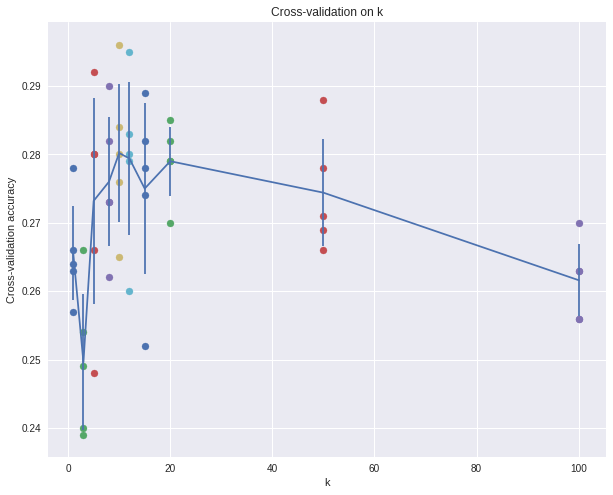

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    print('k = %d, average accuracy = %f' % (k, np.average(accuracies)))
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Inline Question 3**
Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The training error of a 1-NN will always be better than that of 5-NN.
2. The test error of a 1-NN will always be better than that of a 5-NN.
3. The decision boundary of the k-NN classifier is linear.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

*Your Answer*:

*Your explanation*: